In [2]:
!pip install scikit-learn seaborn matplotlib imbalanced-learn --quiet

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

In [1]:
from google.colab import files
import zipfile
import os

# Upload dataset.zip
uploaded = files.upload()

# Extract files
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("fraud_dataset")

# List contents
os.listdir("fraud_dataset")


Saving dataset.zip to dataset.zip


['data']

In [5]:
import glob

# List all pickle files in the extracted 'data' directory
pkl_files = glob.glob("fraud_dataset/data/*.pkl")

# Read each pickle file and concatenate them into a single DataFrame
df_list = [pd.read_pickle(f) for f in pkl_files]
df = pd.concat(df_list, ignore_index=True)

display(df.head())
display(df.info())

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,518169,2018-05-25 00:00:28,955,2587,113.07,4665628,54,0,0
1,518170,2018-05-25 00:00:28,799,9877,74.70,4665628,54,0,0
2,518171,2018-05-25 00:01:22,4736,5082,34.72,4665682,54,0,0
3,518172,2018-05-25 00:01:59,525,7745,42.27,4665719,54,0,0
4,518173,2018-05-25 00:03:20,2123,2753,14.91,4665800,54,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   TRANSACTION_ID     int64         
 1   TX_DATETIME        datetime64[ns]
 2   CUSTOMER_ID        object        
 3   TERMINAL_ID        object        
 4   TX_AMOUNT          float64       
 5   TX_TIME_SECONDS    object        
 6   TX_TIME_DAYS       object        
 7   TX_FRAUD           int64         
 8   TX_FRAUD_SCENARIO  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 120.4+ MB


None

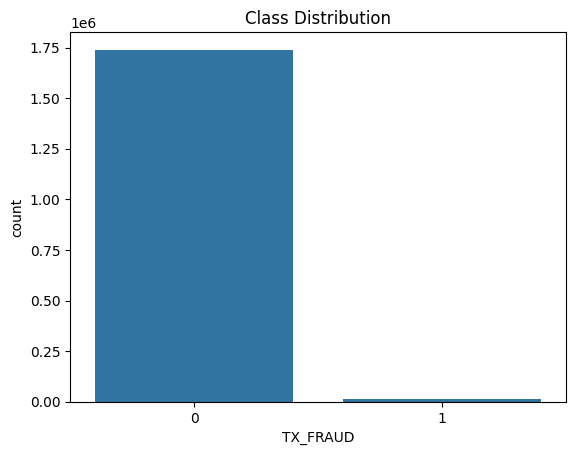

,proportion
TX_FRAUD,
0,0.991631
1,0.008369


In [6]:
sns.countplot(data=df, x='TX_FRAUD')
plt.title("Class Distribution")
plt.show()

display(df['TX_FRAUD'].value_counts(normalize=True))

In [9]:
# Feature-target split
X = df.drop('TX_FRAUD', axis=1)
y = df['TX_FRAUD']

# Drop non-numeric columns that are not needed for modeling
X = X.drop(['TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID'], axis=1)

# Select only numeric columns for scaling
numeric_cols = X.select_dtypes(include=np.number).columns
X_numeric = X[numeric_cols]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Convert scaled array back to DataFrame to keep column names
X_scaled = pd.DataFrame(X_scaled, columns=numeric_cols, index=X.index)

# Drop original numeric columns and concatenate scaled ones
X = X.drop(numeric_cols, axis=1)
X = pd.concat([X, X_scaled], axis=1)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Shape of training data before SMOTE:", X_train.shape)
print("Shape of training data after SMOTE:", X_train_res.shape)
print("Class distribution of training data after SMOTE:\n", y_train_res.value_counts())

Shape of training data before SMOTE: (1403324, 5)
Shape of training data after SMOTE: (2783158, 5)
Class distribution of training data after SMOTE:
 TX_FRAUD
0    1391579
1    1391579
Name: count, dtype: int64


In [3]:
import glob

# Load the data into a DataFrame
pkl_files = glob.glob("fraud_dataset/data/*.pkl")
df_list = [pd.read_pickle(f) for f in pkl_files]
df = pd.concat(df_list, ignore_index=True)


# Feature-target split
X = df.drop('TX_FRAUD', axis=1)
y = df['TX_FRAUD']

# Drop non-numeric columns that are not needed for modeling
X = X.drop(['TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID'], axis=1)

# Select only numeric columns for scaling
numeric_cols = X.select_dtypes(include=np.number).columns
X_numeric = X[numeric_cols]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Convert scaled array back to DataFrame to keep column names
X_scaled = pd.DataFrame(X_scaled, columns=numeric_cols, index=X.index)

# Drop original numeric columns and concatenate scaled ones
X = X.drop(numeric_cols, axis=1)
X = pd.concat([X, X_scaled], axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


model = LogisticRegression(max_iter=1000)
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test)

In [5]:
#Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    347895
           1       1.00      1.00      1.00      2936

    accuracy                           1.00    350831
   macro avg       1.00      1.00      1.00    350831
weighted avg       1.00      1.00      1.00    350831

Confusion Matrix:
 [[347895      0]
 [     0   2936]]
ROC-AUC Score: 1.0


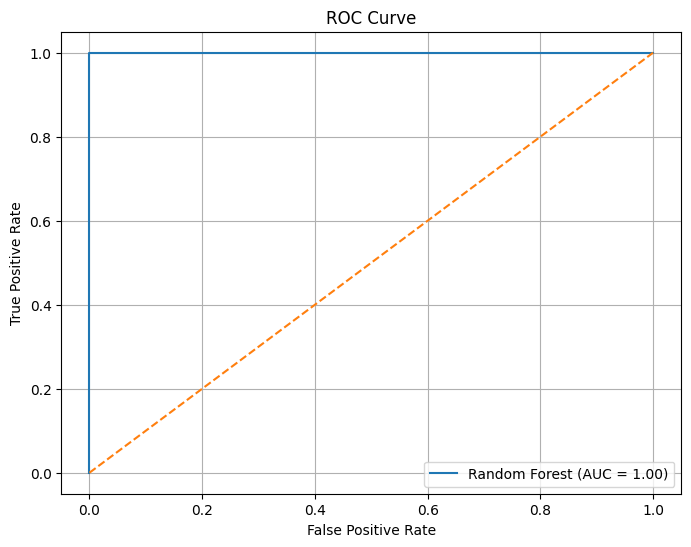

In [8]:
#ROC curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

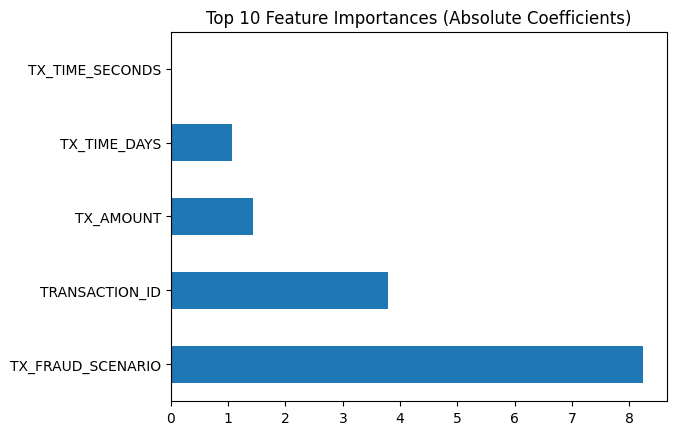

In [7]:
#Feature importance
import pandas as pd
import matplotlib.pyplot as plt

# Get the absolute values of the coefficients
importances = pd.Series(abs(model.coef_[0]), index=X_train_res.columns)

# Sort the importances and plot the top 10
importances.nlargest(10).plot(kind='barh', title='Top 10 Feature Importances (Absolute Coefficients)')
plt.show()